We are going to maximise the Sharpe Ratio with some good performing assets.
These assets are from around the globe, some are from Japan, others from eruope and finally the rest are from the US.


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pypfopt import EfficientFrontier, risk_models, expected_returns
from sklearn.linear_model import LinearRegression

# Paso 1: Descargar los datos de los activos
tickers = ['EUNM.F', 'EGLN.L', 'SPY', 'RACE', 'COST', 'ORLY', 'META', 'GOOGL', 'AAPL', 'MSFT', 'MVUS.MI', 'ROVI.MC', 'AI.PA','STRL','MHVYF']
data = yf.download(tickers, period='5y')['Adj Close']

# Paso 2: Calcular los retornos diarios
returns = data.pct_change().dropna()

# Paso 3: Calcular los retornos esperados y la matriz de covarianza
mu = expected_returns.mean_historical_return(data)
S = risk_models.sample_cov(data)

# Añadir la tasa libre de riesgo a diaria
risk_free_rate = 0.0325 / 252

# Paso 4: Maximizar el ratio de Sharpe ajustado por la tasa libre de riesgo
ef = EfficientFrontier(mu, S, weight_bounds=(0, 1))
weights = ef.max_sharpe(risk_free_rate=risk_free_rate)

# Limpiar los pesos y omitir los que sean 0 absoluto
cleaned_weights = {ticker: weight for ticker, weight in ef.clean_weights().items() if weight > 0}
print("Pesos de la cartera óptima (sin 0s):", cleaned_weights)

# Paso 5: Mostrar el rendimiento esperado, la volatilidad y el ratio de Sharpe
performance = ef.portfolio_performance(verbose=True, risk_free_rate=risk_free_rate)




[*********************100%%**********************]  15 of 15 completed

Pesos de la cartera óptima (sin 0s): {'AAPL': 0.05347, 'COST': 0.11576, 'EGLN.L': 0.40694, 'MHVYF': 0.12698, 'ORLY': 0.0751, 'ROVI.MC': 0.13632, 'STRL': 0.08543}
Expected annual return: 24.9%
Annual volatility: 12.6%
Sharpe Ratio: 1.98



C:\Users\filip\AppData\Local\Temp\ipykernel_24024\1650334176.py:13: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = data.pct_change().dropna()
C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pypfopt\expected_returns.py:56: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change().dropna(how="all")
C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pypfopt\expected_returns.py:56: FutureWa

[*********************100%%**********************]  15 of 15 completed
C:\Users\filip\AppData\Local\Temp\ipykernel_24024\3358948774.py:10: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = data.pct_change().dropna()


C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-pack

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2019-10-22   2019-10-22
End Period                 2024-10-18   2024-10-18
Risk-Free Rate             0.01%        0.01%
Time in Market             97.0%        100.0%

Cumulative Return          84.87%       260.14%
CAGR﹪                     8.87%        19.38%

Sharpe                     0.7          2.05
Prob. Sharpe Ratio         93.89%       100.0%
Smart Sharpe               0.64         1.88
Sortino                    0.97         3.03
Smart Sortino              0.89         2.78
Sortino/√2                 0.68         2.14
Smart Sortino/√2           0.63         1.96
Omega                      1.44         1.44

Max Drawdown               -34.01%      -18.46%
Longest DD Days            713          356
Volatility (ann.)          20.03%       12.58%
R^2                        0.42         0.42
Information Ratio          0.05         0.05
Calmar           

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-02-21,2020-03-23,2020-07-13,144,-18.460003,-16.827747
2,2022-04-14,2022-09-26,2023-04-04,356,-11.944355,-11.679338
3,2024-07-17,2024-08-05,2024-08-28,43,-8.115320,-6.532187
4,2021-01-21,2021-03-08,2021-04-14,84,-7.533027,-7.045101
5,2023-09-19,2023-10-03,2023-11-20,63,-4.289253,-4.100587


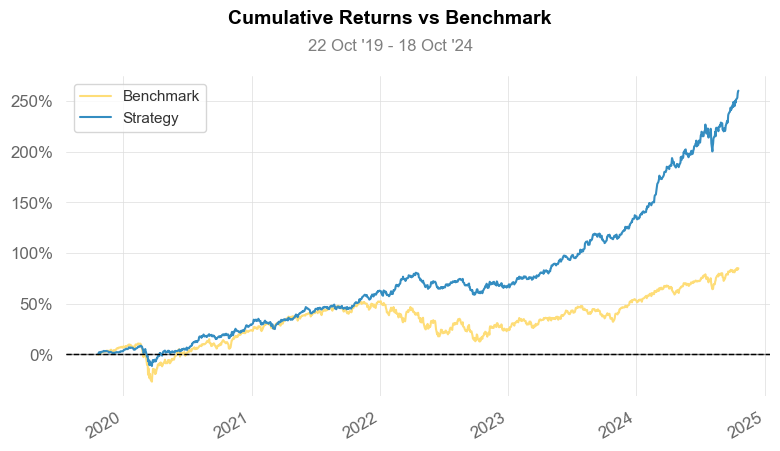

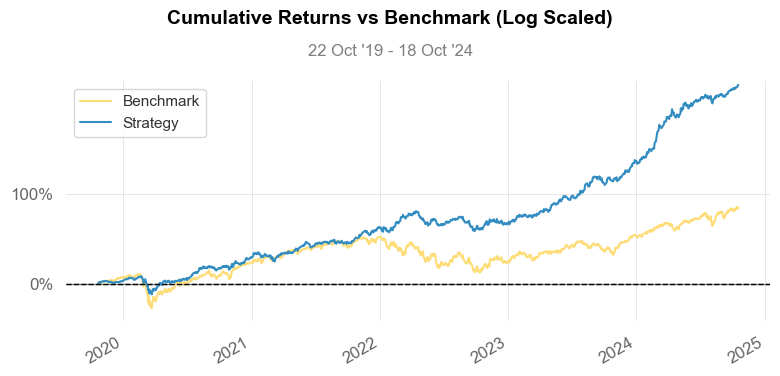

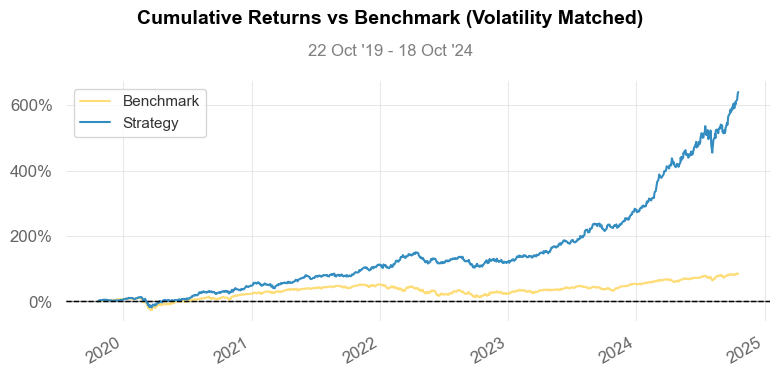

C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\quantstats\_plotting\wrappers.py:555: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  .resample("A")
C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\quantstats\_plotting\wrappers.py:557: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  .resample("A")
C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\quantstats\_plotting\wrappers.py:565: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  returns = returns.resample("A").apply(_stats.comp)
C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra

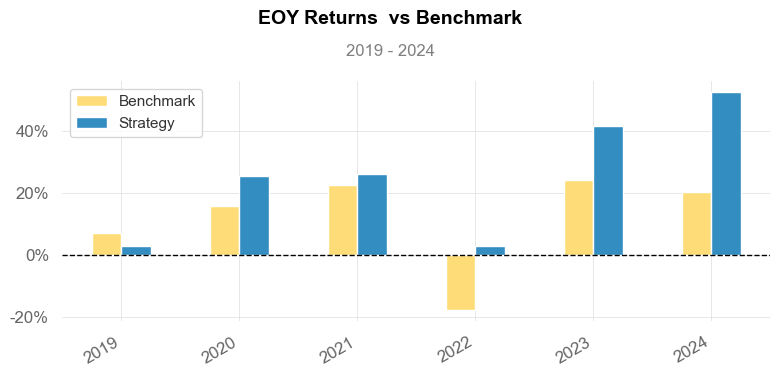

C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\quantstats\_plotting\core.py:433: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample(resample)
C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\quantstats\_plotting\core.py:435: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample(resample)
C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\quantstats\_plotting\core.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  returns.fillna(0).resample(resample).apply(apply_fnc).resample(resample).last()


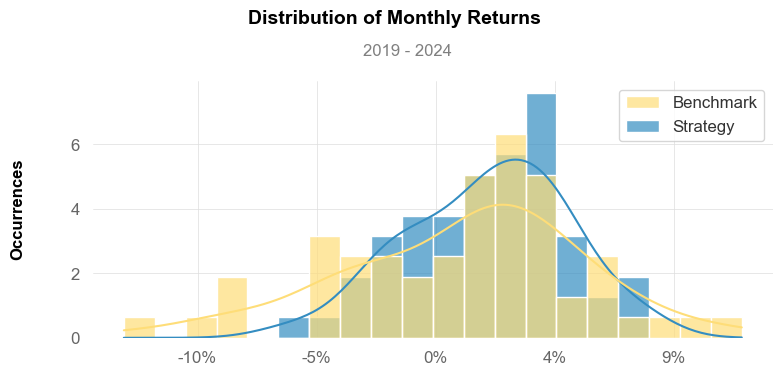

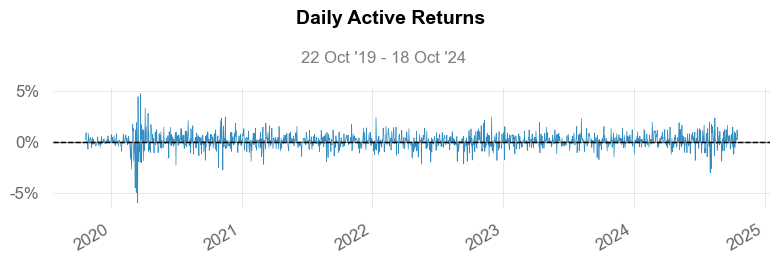

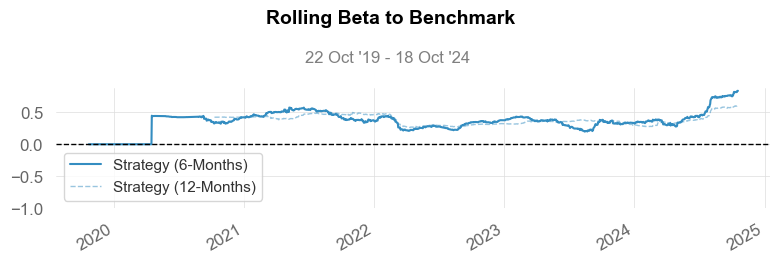

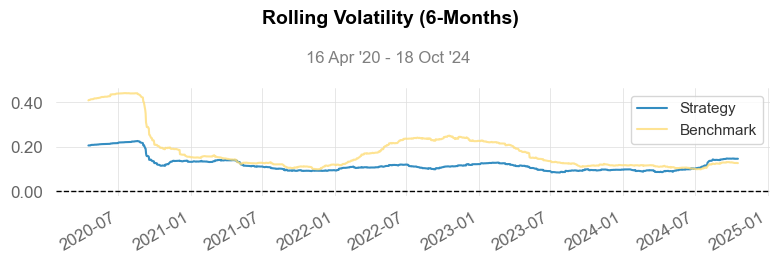

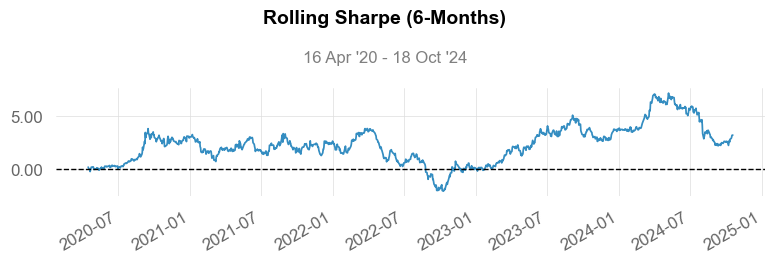

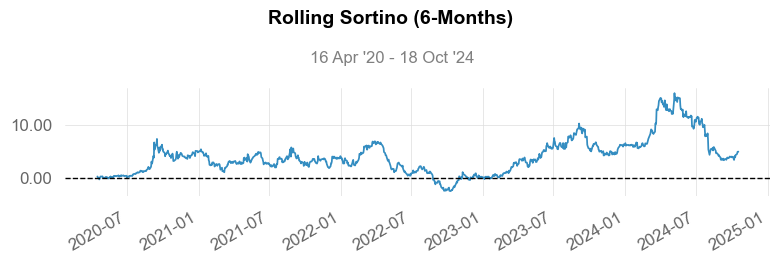

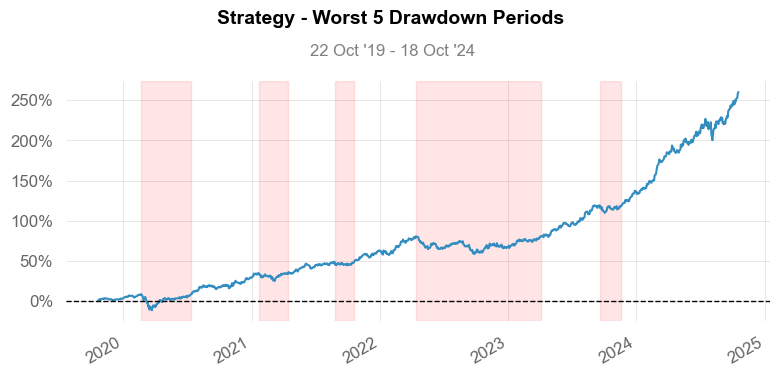

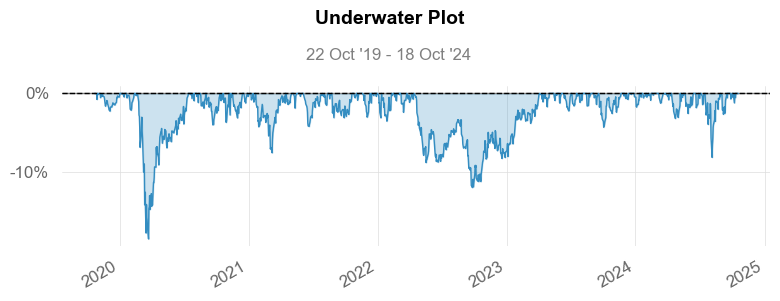

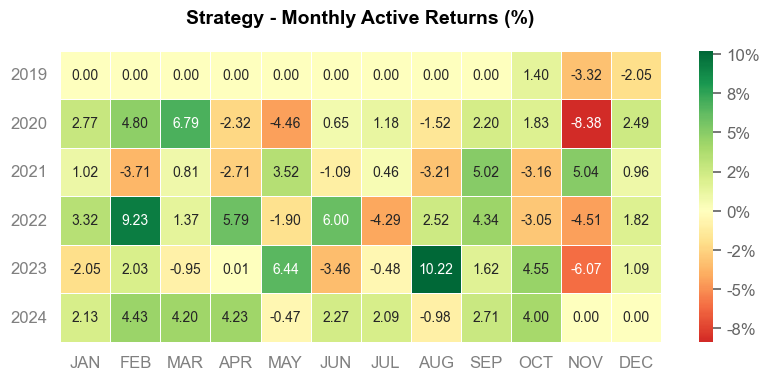

C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\quantstats\_plotting\core.py:1016: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  port["Weekly"].ffill(inplace=True)
C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\quantstats\_plotting\core.py:1018: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  po

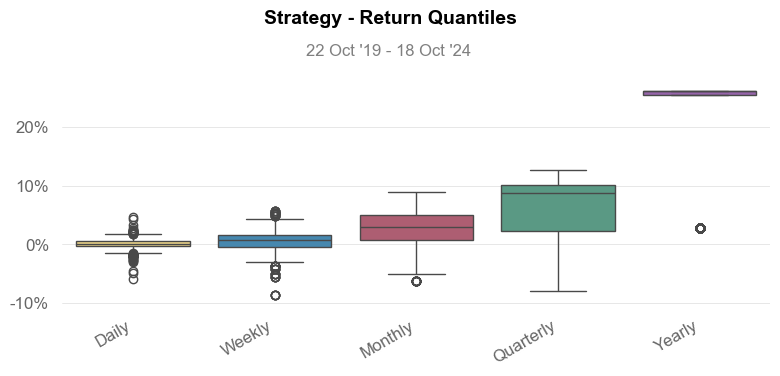

In [4]:
import yfinance as yf
import quantstats as qs
import pandas as pd

# Paso 1: Descargar los datos de los activos
tickers = ['EUNM.F', 'EGLN.L', 'URTH', 'RACE', 'COST', 'ORLY', 'META', 'GOOGL', 'AAPL', 'MSFT', 'MVUS.MI', 'ROVI.MC', 'AI.PA','STRL','MHVYF']
data = yf.download(tickers, period='5y')['Adj Close']

# Paso 2: Calcular los retornos diarios
returns = data.pct_change().dropna()

# Paso 3: Seleccionar URTH como benchmark y calcular los retornos de la cartera óptima
optimal_weights = {'AAPL': 0.05347, 'COST': 0.11576, 'EGLN.L': 0.40694, 'MHVYF': 0.12698, 'ORLY': 0.0751, 'ROVI.MC': 0.13632, 'STRL': 0.08543}

# Filtrar los retornos de los activos en la cartera y calcular los retornos ponderados
selected_returns = returns[list(optimal_weights.keys())]
portfolio_returns = (selected_returns * pd.Series(optimal_weights)).sum(axis=1)

# Paso 4: Definir la tasa libre de riesgo anual y convertirla a diaria
risk_free_rate_annual = 0.0325
risk_free_rate_daily = risk_free_rate_annual / 252

# Generar el informe completo con QuantStats
qs.reports.full(portfolio_returns, benchmark=returns['URTH'], rf=risk_free_rate_daily)
